# **This notebook is used for the implementation of a linear regression model to predict house prices.**

### Let's start by importing the relevant modules.

In [146]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

### The dataset used is from Kaggle's Housing Prices Dataset.

### The training data contains 13 features(X), as well as the target(y).

In [147]:
df = pd.read_csv('/Users/georgeprice/Downloads/Housing.csv')

### Using NumPy and Pandas, I will now ensure the data is clean.

### I will also analyse and visulaise the data using Matplotlib.

In [148]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [150]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [151]:
df.describe().round(decimals=2)

,price,area,bedrooms,bathrooms,stories,parking
count,545.00,545.00,545.00,545.00,545.00,545.00
mean,4766729.25,5150.54,2.97,1.29,1.81,0.69
std,1870439.62,2170.14,0.74,0.50,0.87,0.86
min,1750000.00,1650.00,1.00,1.00,1.00,0.00
25%,3430000.00,3600.00,2.00,1.00,1.00,0.00
50%,4340000.00,4600.00,3.00,1.00,2.00,0.00
75%,5740000.00,6360.00,3.00,2.00,2.00,1.00
max,13300000.00,16200.00,6.00,4.00,4.00,3.00


### As shown, there are no null values in this dataset. I will now engineer a new feature, price per sqft.

In [152]:
df['price per sqft'] = df['price'] / df['area']

### I will now plot the data to see if there are any correlations and if any conclusions can be drawn.

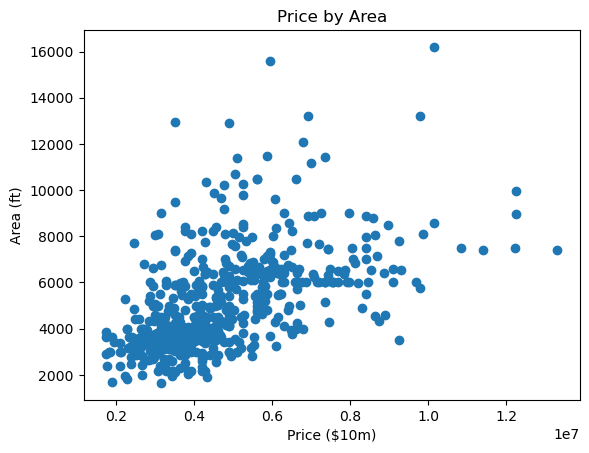

In [153]:
plt.scatter(df['price'], df['area'], marker='o', label = 'data')
plt.xlabel('Price ($10m)')
plt.ylabel('Area (ft)')
plt.title('Price by Area')
plt.show()

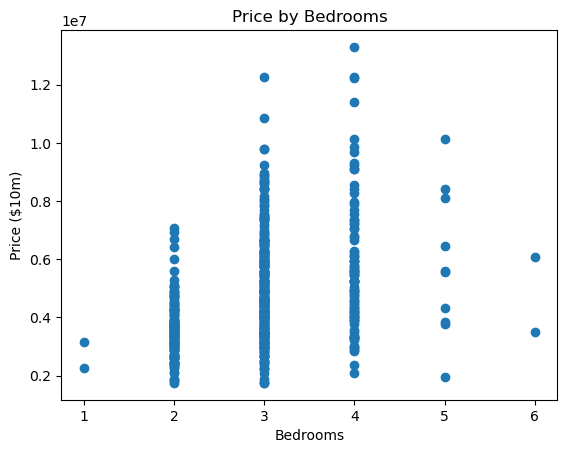

In [154]:
plt.scatter(df['bedrooms'], df['price'], marker='o')
plt.xlabel('Bedrooms')
plt.ylabel('Price ($10m)')
plt.title('Price by Bedrooms')
plt.show()

### Having looked at the above scatter graphs, it could be considered that the house prices above $12,000,000 do not follow the trend. I have deceided to leave these records in the dataset as opposed to dropping them.

### I also looked at the zscore for each property's price per sqft. Having found the highest zscore, I've decided to keep this entry in, given the other variables which would justify the higher house price (bedrooms, parking).

In [155]:
df.query('price > 12000000')

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price per sqft
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,1792.452830
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,1367.187500
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,1229.919679
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,1628.666667


In [156]:
from scipy import stats
stats.zscore(df['price per sqft']).sort_values().tail(15)

243    2.284643
0      2.308152
295    2.348585
337    2.409397
108    2.575549
23     2.606750
449    2.645043
345    2.649604
18     2.712970
157    2.765099
302    2.786430
282    2.801382
20     2.981165
271    3.711201
13     4.756161
Name: price per sqft, dtype: float64

In [157]:
z_scores = pd.Series(stats.zscore(df['price per sqft']), index=df.index)
min_index = z_scores.idxmax()
lowest_row = df.loc[min_index]
print(lowest_row)

price                 9240000
area                     3500
bedrooms                    4
bathrooms                   2
stories                     2
mainroad                  yes
guestroom                  no
basement                   no
hotwaterheating           yes
airconditioning            no
parking                     2
prefarea                   no
furnishingstatus    furnished
price per sqft         2640.0
Name: 13, dtype: object


### As expected, a house's price is only loosely based on it's size and number of bedrooms. There are many other factors that weren't considered in the above scatter graphs.

### These factors will be included in the below linear regression model.

In [158]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [159]:
gdfg

NameError: name 'gdfg' is not defined

### I will now create a pipeline and encode the categorical data for use in the linear regression model. I will also implement feature scaling.

In [182]:
num_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
cat_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

In [183]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ]
)

In [184]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [185]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['mainroad', 'guestroom',
                                                   'basement',
                                                   'hotwaterheating',
                                                   'airconditioning',
                                                   'prefarea',
                                                   'furnishingstatus'])])),
                ('regressor', LinearRegression())])

### MODEL EVALUATION - I have shown the Mean Absolute Error, Root Mean Squared Error and R2 Score.

In [186]:
y_pred = pipeline.predict(X_test)

In [187]:
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)

print(f'The Mean Absolute Error is: ', MAE)
print(f'The Root Mean Squared Error is: ', RMSE)
print(f'The R2 Score is: ', R2)

The Mean Absolute Error is:  758727.4314304597
The Root Mean Squared Error is:  1036228.8468229527
The R2 Score is:  0.6732710479367144


### Importing Joblib to save the model for future use.

In [169]:
import joblib
joblib.dump(pipeline, 'House-Price-Predictor.pkl')

['House-Price-Predictor.pkl']